In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sqlite3 as sql
from sqlalchemy import *

%matplotlib inline  
import seaborn as sns
sns.set_theme(style="darkgrid")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## I. Extraction et transformation des CSV principaux

In [2]:
effectifEcoles =  pd.read_csv('../data/effectifs_ecolesnantes.csv', header=0, sep=';')
effectifEcoles.drop(['Début année scolaire'], axis=1, inplace=True)
effectifEcoles.head()

,Ecole,Année scolaire,Effectif
0,ALAIN FOURNIER MATERNELLE,2010-2011,114
1,BAUT ELEMENTAIRE,2010-2011,98
2,BEAUJOIRE ELEMENTAIRE,2010-2011,119
3,CHARLES LEBOURG PRIMAIRE,2010-2011,169
4,CHENE D'ARON MATERNELLE,2010-2011,78


In [3]:
appariement = pd.read_csv('../data/appariement_ecoles_cantines.csv', header=0, sep=',')
appariement.rename(columns={"ecole": "Ecole"}, inplace=True)
appariement.head()

,Ecole,cantine_nom,cantine_type
0,CONTRIE MATERNELLE,CONTRIE,M/E
1,VILLA MARIA PRIMAIRE,VILLA MARIA,M/E
2,LINOT ELEMENTAIRE,LINOT,M/E
3,LOUISE MICHEL MATERNELLE,LOUISE MICHEL,M/E
4,PLESSIS CELLIER MATERNELLE,PLESSIS CELLIER,M/E


### Récuparation de l'effectif aggrégé par cantines

In [4]:
effectifEcoles = pd.merge(effectifEcoles, appariement[['cantine_nom','Ecole']], on='Ecole')
effectifEcoles.rename(columns={'Année scolaire':'annee_scolaire'}, inplace=True)
effectifCantines = effectifEcoles.groupby(['annee_scolaire','cantine_nom'], as_index=False).sum()
effectifCantines.cantine_nom.nunique()

87

### Récupération du CSV principal : la fréquentation journalière

In [5]:
freqJ = pd.read_csv('../data/frequentation_cantines_v2.csv',
                    header=0, sep=',', low_memory=False)
freqJ["date"] = pd.to_datetime(freqJ["date"])

# drop useless columns
freqJ.drop(['site_nom_sal', 'site_id', 'prevision_s', 'reel_s'], axis=1, inplace=True)
freqJ.rename(columns={'site_nom':'cantine_nom'}, inplace=True)
freqJ.sort_values(by='date', inplace=True, ascending=True)
freqJ.reset_index(inplace=True, drop=True)
freqJ.head()

,site_type,date,prevision,reel,cantine_nom
0,M/E,2011-01-03,210.0,182.0,AMPERE
1,M/E,2011-01-03,130.0,115.0,PAUL GAUGUIN
2,M,2011-01-03,90.0,77.0,COUDRAY M.
3,M,2011-01-03,49.0,NaN,COTE DOR
4,E,2011-01-03,174.0,159.0,MAURICE MACE


### Jointure avec l'année scolaire

In [6]:
def get_school_year(data, date_col, data_path):
    """
    add a new column annee_scolaire with annees_scolaires.csv file to the main dataframe
    """

     # generate all dates within start and end
    start = data[date_col].min()
    end = data[date_col].max()
    df = pd.date_range(start, end, freq="D").to_frame(index=False, name="date")

    # read external holidays csv
    def _parser(date):
        return pd.to_datetime(date)

    holidays = pd.read_csv(f'{data_path}',
                              parse_dates=['date_debut', 'date_fin'],
                              date_parser=_parser)
    holidays = holidays[["annee_scolaire", "date_debut", "date_fin"]]
    holidays = holidays.drop_duplicates()

    # simulate an interval based left join using pandas
    # perform a cross join on temp_key
    up_bound = "date_fin"
    low_bound = "date_debut"
    df['temp_key'] = 1
    holidays['temp_key'] = 1
    crossjoindf = pd.merge(df, holidays, on=['temp_key'])

    df.drop(columns=['temp_key'], inplace=True)
    crossjoindf.drop(columns=['temp_key'], inplace=True)
    
    # filter with lower_bound & upper_bound
    conditionnal_df = crossjoindf[
        (crossjoindf["date"] >= crossjoindf[low_bound]) & (crossjoindf["date"] <= crossjoindf[up_bound])]

    # merge on the main df with all cols as keys to simulate left join
    df_col = df.columns.values.tolist()
    conditionnal_df.set_index(df_col, inplace=True)
    df = df.merge(conditionnal_df, left_on=df_col, right_index=True, how='left')

    df.set_index('date', inplace=True) 
    data = pd.merge(data, df['annee_scolaire'], on='date')
    
    return data

freqJ = get_school_year(freqJ, 'date', '../data/annees_scolaires.csv')
freqJ.head()

,site_type,date,prevision,reel,cantine_nom,annee_scolaire
0,M/E,2011-01-03,210.0,182.0,AMPERE,2010-2011
1,M/E,2011-01-03,130.0,115.0,PAUL GAUGUIN,2010-2011
2,M,2011-01-03,90.0,77.0,COUDRAY M.,2010-2011
3,M,2011-01-03,49.0,NaN,COTE DOR,2010-2011
4,E,2011-01-03,174.0,159.0,MAURICE MACE,2010-2011


### Jointure avec l'effectif des cantines

In [7]:
freqJ = pd.merge(freqJ, effectifCantines[['annee_scolaire', 'cantine_nom', 'Effectif']], on=['annee_scolaire', 'cantine_nom'])
freqJ.cantine_nom.nunique()

86

## Enrichissement avec des variables d'intérêt pour l'analyse exploratoire

Hypothèse après échanges avec le personnel scolaire : bien souvent les parents retirent leurs enfants quelques jours avant les vacances ou ne reviennent que quelques jours après sous différents pretextes. Il en va de même pour les jours férriés. On peut donc créer ces variables afin de voir l'impact qu'elles ont sur la cible lors de l'EDA.

### Indicateurs de proximité par rapport aux vacances

In [8]:
def distance_holidays(data, date_col, data_path):
    """
    add features about how close we are from next holidays and how far from last holidays
    this may help the model to better understand how this proximity can impact canteens frequentation  
    """

    # generate all dates within start and end
    start = data[date_col].min()
    end = data[date_col].max()
    df = pd.date_range(start, end, freq="D").to_frame(index=False, name="date")

    # read external holidays csv
    def _parser(date):
        return pd.to_datetime(date)

    holidays = pd.read_csv(f'{data_path}',
                              parse_dates=['date_debut', 'date_fin'],
                              date_parser=_parser)
    holidays = holidays[["vacances_nom", "date_debut", "date_fin", "zone", "vacances"]]
    holidays = holidays.drop_duplicates()

    # simulate an interval based left join using pandas
    # perform a cross join on temp_key
    up_bound = "date_fin"
    low_bound = "date_debut"
    df['temp_key'] = 1
    holidays['temp_key'] = 1
    crossjoindf = pd.merge(df, holidays, on=['temp_key'])

    df.drop(columns=['temp_key'], inplace=True)
    crossjoindf.drop(columns=['temp_key'], inplace=True)
    
    # filter with lower_bound & upper_bound
    conditionnal_df = crossjoindf[
        (crossjoindf["date"] >= crossjoindf[low_bound]) & (crossjoindf["date"] <= crossjoindf[up_bound])]

    # merge on the main df with all cols as keys to simulate left join
    df_col = df.columns.values.tolist()
    conditionnal_df.set_index(df_col, inplace=True)
    df = df.merge(conditionnal_df, left_on=df_col, right_index=True, how='left')
 
    # find rows index corresponding to holidays
    holidays_index = np.where(~df['vacances_nom'].isnull())[0]

    # compute arrays of first day and last day of holidays
    holidays_min_index = []
    holidays_max_index = []
    i = 0
    while i < len(holidays_index):
        j = 0
        while i + j < len(holidays_index) and (holidays_index[i] + j) == holidays_index[i + j]:
            j += 1
        holidays_min_index.append(holidays_index[i])
        holidays_max_index.append(holidays_index[i + j - 1])
        i += j

    indexes = range(0, len(df)) 
    
    # compute for each index row the distance with the nearest upcoming holidays
    df['vacances_dans'] = [min([i - x for i in holidays_min_index if i > x], default=0) for x in indexes]
    
    # compute for each index row the distance with the latest past holidays
    df['depuis_vacances'] = [min([x - i for i in holidays_max_index if i < x], default=0) for x in indexes]
    
    # set holidays_in and holidays_ago to 0 during effective holidays
    df.loc[~df['vacances_nom'].isnull(), 'vacances_dans'] = 0
    df.loc[~df['vacances_nom'].isnull(), 'depuis_vacances'] = 0
    
    df.set_index('date', inplace=True)
    data = pd.merge(data, df[['vacances_dans', 'depuis_vacances']], on='date')
    
    return data

freqJ = distance_holidays(freqJ, 'date', '../data/vacances.csv')
freqJ.head()

,site_type,date,prevision,reel,cantine_nom,annee_scolaire,Effectif,vacances_dans,depuis_vacances
0,M/E,2011-01-03,210.0,182.0,AMPERE,2010-2011,280,54,0
1,M/E,2011-01-03,130.0,115.0,PAUL GAUGUIN,2010-2011,244,54,0
2,M,2011-01-03,90.0,77.0,COUDRAY M.,2010-2011,103,54,0
3,M/E,2011-01-03,106.0,113.0,GRAND CARCOUET,2010-2011,141,54,0
4,M/E,2011-01-03,190.0,177.0,BATIGNOLLES,2010-2011,266,54,0


### Indicateurs de proximité par rapport aux jours fériés

In [9]:
def distance_public(data, date_col, data_path):
    """"
    add features about how close we are from next public holidays and how far from last public holidays
    this may help the model to better understand how this proximity can impact canteens frequentation
    """

    # generate all dates within start and end 
    start = data[date_col].min()
    end = data[date_col].max()
    df = pd.date_range(start, end, freq="D").to_frame(index=False, name="_date")

    # read external holidays csv
    def _parser(date):
        return pd.to_datetime(date)

    pub_holidays = pd.read_csv(f'{data_path}', parse_dates=['date'], date_parser=_parser)
    pub_holidays = pub_holidays[["date", "nom_jour_ferie"]]
    pub_holidays = pub_holidays.drop_duplicates()

    # simulate an interval based left join using pandas
    # perform a cross join on temp_key
    low_bound = "date"
    df['temp_key'] = 1
    pub_holidays['temp_key'] = 1
    
    crossjoindf = pd.merge(df, pub_holidays, on=['temp_key'])
    df.drop(columns=['temp_key'], inplace=True)
    crossjoindf.drop(columns=['temp_key'], inplace=True)
     
    # filter with lower_bound  
    conditionnal_df = crossjoindf[(crossjoindf['_date'] == crossjoindf[low_bound])]

    # merge on the main df with all cols as keys to simulate left join
    df_col = df.columns.values.tolist()
    conditionnal_df.set_index(df_col, inplace=True)
    df = df.merge(conditionnal_df, left_on=df_col, right_index=True, how='left')
 
    # find rows index corresponding to holidays
    pub_holidays_index = np.where(~df['nom_jour_ferie'].isnull())[0]

    # compute arrays of first day and last day of holidays
    pub_holidays_min_index = []
    pub_holidays_max_index = []
    i = 0
    while i < len(pub_holidays_index):
        j = 0
        while i + j < len(pub_holidays_index) and (pub_holidays_index[i] + j) == pub_holidays_index[i + j]:
            j += 1
        pub_holidays_min_index.append(pub_holidays_index[i])
        pub_holidays_max_index.append(pub_holidays_index[i + j - 1])
        i += j

    indexes = range(0, len(df)) 
    
    # compute for each index row the distance with the nearest upcoming public holiday
    df['ferie_dans'] = [min([i - x for i in pub_holidays_min_index if i > x], default=0) for x in indexes]
    
    # compute for each index row the distance with the latest past holidays
    df['depuis_ferie'] = [min([x - i for i in pub_holidays_max_index if i < x], default=0) for x in indexes]
    
    # set pub_holidays_in and pub_holidays_ago to 0 during effective holidays
    df.loc[~df['nom_jour_ferie'].isnull(), 'ferie_dans'] = 0
    df.loc[~df['nom_jour_ferie'].isnull(), 'depuis_ferie'] = 0
    
    # we drop date col that was just useful to define lower_bound 
    # and we rename _date to have the same key name to join both dataframes
    df.drop(columns=['date'], inplace=True)
    df.rename(columns={"_date": "date"}, inplace=True)
    df.set_index('date', inplace=True)
    data = pd.merge(data, df[['ferie_dans', 'depuis_ferie']], on='date')
    
    return data

freqJ = distance_public(freqJ, 'date', '../data/jours_feries.csv')
freqJ.head()

,site_type,date,prevision,reel,cantine_nom,annee_scolaire,Effectif,vacances_dans,depuis_vacances,ferie_dans,depuis_ferie
0,M/E,2011-01-03,210.0,182.0,AMPERE,2010-2011,280,54,0,112,0
1,M/E,2011-01-03,130.0,115.0,PAUL GAUGUIN,2010-2011,244,54,0,112,0
2,M,2011-01-03,90.0,77.0,COUDRAY M.,2010-2011,103,54,0,112,0
3,M/E,2011-01-03,106.0,113.0,GRAND CARCOUET,2010-2011,141,54,0,112,0
4,M/E,2011-01-03,190.0,177.0,BATIGNOLLES,2010-2011,266,54,0,112,0


## II. Extraction et intégration des CSV concernant les événements religieux 

Comme exposé dans le cahier des charges, nous n'integrerons pas les grèves dans l'analyse le modèle doit aider les agents dans la prévision des périodes normales.

De même, nous n'aurons pas l'informatio sur la grève au moment de la prédiction.

In [10]:
greves = pd.read_csv('../data/greves_restauration_et_ou_ecoles.csv', header=0, sep=',')
greves["date"] = pd.to_datetime(greves["date"])
greves.head()

,date,greve
0,2011-12-15,1
1,2011-10-02,1
2,2011-05-16,1
3,2011-03-28,1
4,2011-11-10,1


In [11]:
# utilisation des regex pour nettoyer les datasets suivants
import re

def get_year(date):
    x = re.findall('([\d]{4})', date)
    if x :
        return x[0]
    
def get_month(date):
    x = re.findall('^[A-Z][a-zéû]+', date)
    if x:
        return x[0]

def get_day(date):
    return date[-2:]

In [12]:
chretiennes = pd.read_csv('../data/fetes_chretiennes.csv',
                          header=None, sep=',', encoding="ISO-8859-1")

chretiennes['Année'] = chretiennes[1].apply(get_year)
chretiennes['Mois'] = chretiennes[1].apply(get_month).map({"Janvier": "01", "Février": "02", "Mars": "03", "Avril": "04",
                                                           "Mai": "05", "Juin": "06", "Juillet": "07", "Août": "08", "Septembre": "09",
                                                           "Octobre": "10", "Novembre": "11", "Décembre": "12"})
chretiennes['Jour'] = chretiennes[0].apply(get_day)
chretiennes['Jour'] = chretiennes['Jour'].apply(lambda x: x.zfill(2))

chretiennes['date'] = chretiennes['Jour'].astype(
    str) + '/' + chretiennes['Mois'].astype(str) + '/' + chretiennes['Année'].astype(str)
chretiennes['date']
chretiennes.drop([0, 1, 2, 3, 4, 5, 'Année', 'Mois', 'Jour'],
                 axis=1, inplace=True)
chretiennes['chretiennes'] = 1
chretiennes["date"] = pd.to_datetime(chretiennes["date"], format="%d/%m/%Y")

chretiennes.head()

,date,chretiennes
0,2011-01-02,1
1,2011-01-06,1
2,2011-01-07,1
3,2011-01-18,1
4,2011-01-19,1


In [13]:
juives = pd.read_csv('../data/fetes_juives.csv', header=None,
                     sep=',', encoding="ISO-8859-1")
juives['Année'] = juives[1].apply(get_year)
juives['Mois'] = juives[1].apply(get_month).map({"Janvier": "01", "Février": "02", "Mars": "03", "Avril": "04",
                                                 "Mai": "05", "Juin": "06", "Juillet": "07", "Août": "08", "Septembre": "09",
                                                 "Octobre": "10", "Novembre": "11", "Décembre": "12"})
juives['Jour'] = juives[0].apply(get_day)
juives['Jour'] = juives['Jour'].apply(lambda x: x.zfill(2))
juives['date'] = juives['Jour'].astype(
    str) + '/' + juives['Mois'].astype(str) + '/' + juives['Année'].astype(str)

juives.drop([0, 1, 2, 3, 4, 5, 'Année', 'Mois', 'Jour'], axis=1, inplace=True)
juives['juives'] = 1
juives["date"] = pd.to_datetime(juives["date"], format="%d/%m/%Y")

juives.head()

,date,juives
0,2011-03-20,1
1,2011-04-19,1
2,2011-06-08,1
3,2011-08-09,1
4,2011-09-29,1


In [14]:
musulm = pd.read_csv('../data/fetes_musulmanes.csv', header=None, sep=',', encoding = "ISO-8859-1")

musulm.drop([1,2,3,4,5,6], axis=1, inplace=True)
musulm.rename(columns={0: "date"}, inplace=True)

musulm['musulmanes'] = 1
musulm["date"] = musulm["date"].str.replace(" ", "")
musulm["date"] = pd.to_datetime(musulm["date"], format="%d/%m/%Y")

musulm.head()

,date,musulmanes
0,2011-02-15,1
1,2011-07-29,1
2,2011-08-01,1
3,2011-08-27,1
4,2011-08-30,1


In [15]:
ramad = pd.read_csv('../data/ramad.csv', header=None, sep=',')
ramad.rename(columns={0: "date", 1: "ramadan"}, inplace=True)
ramad["date"] = pd.to_datetime(ramad["date"], format="%d/%m/%Y")
ramad.head()

,date,ramadan
0,2021-04-13,1
1,2021-04-14,1
2,2021-04-15,1
3,2021-04-16,1
4,2021-04-17,1


In [16]:
def merge_religious_days(data, date_col, religion_dfs):
    """"
    merge religion dataframes based on the length of the whole time serie
    """

    # generate all dates within start and end
    start = data[date_col].min()
    end = data[date_col].max()
    religion_df = pd.date_range(start, end, freq="D").to_frame(index=False, name="date")
 
    for rel in religion_dfs:
        religion_df = pd.merge(religion_df, rel, how='left', on='date')
        
    religion_df = religion_df.fillna(0)
    
    return religion_df

In [17]:
religion_dfs = [chretiennes, juives, ramad, musulm, greves]
religion_df = merge_religious_days(freqJ, 'date', religion_dfs)
religion_df.head()

,date,chretiennes,juives,ramadan,musulmanes,greve
0,2011-01-03,0.0,0.0,0.0,0.0,0.0
1,2011-01-04,0.0,0.0,0.0,0.0,0.0
2,2011-01-05,0.0,0.0,0.0,0.0,0.0
3,2011-01-06,1.0,0.0,0.0,0.0,0.0
4,2011-01-07,1.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='date', ylabel='ramadan'>

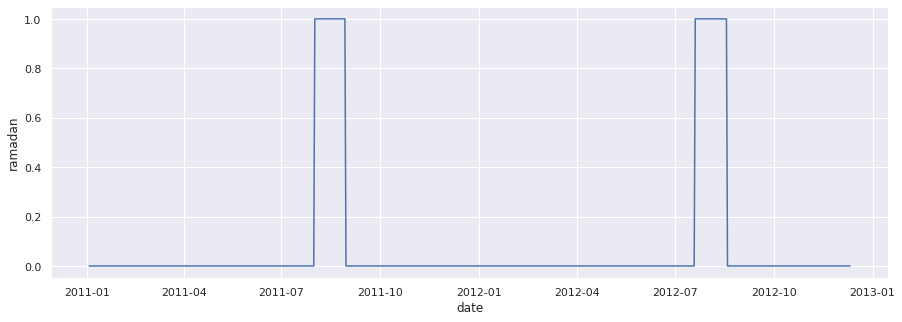

In [18]:
plt.subplots(figsize=(15, 5))
sns.lineplot(data=religion_df[religion_df['date']<'2012-12-12'], x="date", y="ramadan")

In [19]:
religion_df.to_csv('../data/events.csv', index=False)

### Indicateurs proximité par rapport aux fêtes religieuses

La même hypothèse que pour les vacances et les jours fériés motive la création de ces features pour l'analyse.

In [20]:
def events_in_ago(data, date_col, data_path):
    """"
    add features about how close we are from next public holidays and how far from last public holidays
    this may help the model to better understand how this proximity can impact canteens frequentation
    """

    # generate all dates within start and end 
    start = data[date_col].min()
    end = data[date_col].max()
    dfs = pd.date_range(start, end, freq="D").to_frame(index=False, name="_date")

    # read external holidays csv
    def _parser(date):
        return pd.to_datetime(date)

    events = pd.read_csv(f'{data_path}', parse_dates=['date'], date_parser=_parser)

    for col in ['chretiennes', 'juives', 'ramadan', 'musulmanes']:
        df = dfs.copy()
        event = events.copy()
        event = event[["date", col]]
        event = event[event[col] != 0]
        event = event.drop_duplicates()

        # simulate an interval based left join using pandas
        # perform a cross join on temp_key
        low_bound = "date"
        df['temp_key'] = 1
        event['temp_key'] = 1

        crossjoindf = pd.merge(df, event, on=['temp_key'])
        df.drop(columns=['temp_key'], inplace=True)
        crossjoindf.drop(columns=['temp_key'], inplace=True)

        # filter with lower_bound  
        conditionnal_df = crossjoindf[(crossjoindf['_date'] == crossjoindf[low_bound])]

        # merge on the main df with all cols as keys to simulate left join
        df_col = df.columns.values.tolist()
        conditionnal_df.set_index(df_col, inplace=True)
        df = df.merge(conditionnal_df, left_on=df_col, right_index=True, how='left')

        # find rows index corresponding to holidays
        events_index = np.where(~df[col].isnull())[0]

        # compute arrays of first day and last day of holidays
        events_min_index = []
        events_max_index = []
        i = 0
        while i < len(events_index):
            j = 0
            while i + j < len(events_index) and (events_index[i] + j) == events_index[i + j]:
                j += 1
            events_min_index.append(events_index[i])
            events_max_index.append(events_index[i + j - 1])
            i += j

        indexes = range(0, len(df)) 

        # compute for each index row the distance with the nearest upcoming public holiday
        df[col + '_dans'] = [min([i - x for i in events_min_index if i > x], default=0) for x in indexes]

        # compute for each index row the distance with the latest past holidays
        df[ 'depuis_' + col] = [min([x - i for i in events_max_index if i < x], default=0) for x in indexes]

        # set pub_holidays_in and pub_holidays_ago to 0 during effective holidays
        df.loc[~df[col].isnull(), col + '_dans'] = 0
        df.loc[~df[col].isnull(), 'depuis_' + col] = 0

        # we drop date col that was just useful to define lower_bound 
        # and we rename _date to have the same key name to join both dataframes
        df.drop(columns=['date'], inplace=True)
        df.rename(columns={"_date": "date"}, inplace=True)
        df.set_index('date', inplace=True)
        data = pd.merge(data, df[[col + '_dans', 'depuis_' + col]], on='date')
    
    return data

freqJ = events_in_ago(freqJ, 'date', '../data/events.csv')
freqJ.head()

,site_type,date,prevision,reel,cantine_nom,annee_scolaire,Effectif,vacances_dans,depuis_vacances,ferie_dans,depuis_ferie,chretiennes_dans,depuis_chretiennes,juives_dans,depuis_juives,ramadan_dans,depuis_ramadan,musulmanes_dans,depuis_musulmanes
0,M/E,2011-01-03,210.0,182.0,AMPERE,2010-2011,280,54,0,112,0,3,0,76,0,210,0,43,0
1,M/E,2011-01-03,130.0,115.0,PAUL GAUGUIN,2010-2011,244,54,0,112,0,3,0,76,0,210,0,43,0
2,M,2011-01-03,90.0,77.0,COUDRAY M.,2010-2011,103,54,0,112,0,3,0,76,0,210,0,43,0
3,M/E,2011-01-03,106.0,113.0,GRAND CARCOUET,2010-2011,141,54,0,112,0,3,0,76,0,210,0,43,0
4,M/E,2011-01-03,190.0,177.0,BATIGNOLLES,2010-2011,266,54,0,112,0,3,0,76,0,210,0,43,0


In [21]:
data = pd.merge(freqJ, religion_df, how='left', on='date')
data.sort_index(inplace=True, ascending=True)
data.sort_values(by='date', inplace=True, ascending=True)
data.reset_index(inplace=True, drop=True)
data.head()

,site_type,date,prevision,reel,cantine_nom,annee_scolaire,Effectif,vacances_dans,depuis_vacances,ferie_dans,depuis_ferie,chretiennes_dans,depuis_chretiennes,juives_dans,depuis_juives,ramadan_dans,depuis_ramadan,musulmanes_dans,depuis_musulmanes,chretiennes,juives,ramadan,musulmanes,greve
0,M/E,2011-01-03,210.0,182.0,AMPERE,2010-2011,280,54,0,112,0,3,0,76,0,210,0,43,0,0.0,0.0,0.0,0.0,0.0
1,M/E,2011-01-03,100.0,93.0,JACQUES TATI,2010-2011,185,54,0,112,0,3,0,76,0,210,0,43,0,0.0,0.0,0.0,0.0,0.0
2,M/E,2011-01-03,267.0,241.0,FRANCOIS DALLET/DOCTEUR TEILLAIS,2010-2011,339,54,0,112,0,3,0,76,0,210,0,43,0,0.0,0.0,0.0,0.0,0.0
3,M/E,2011-01-03,197.0,184.0,HAROUYS,2010-2011,256,54,0,112,0,3,0,76,0,210,0,43,0,0.0,0.0,0.0,0.0,0.0
4,M/E,2011-01-03,271.0,227.0,LOUISE MICHEL,2010-2011,365,54,0,112,0,3,0,76,0,210,0,43,0,0.0,0.0,0.0,0.0,0.0


## III. Extraction et intégration des features géographiques

Maintenant que nous avons créer notre principale table d'analyse, nous pouvons poursuivre l'intégration de données supplémentaires. Ici, nous nous intéressons à des données géographique. 

In [22]:
appariement = pd.read_csv('../data/appariement_ecoles_cantines.csv', header=0, sep=',')
appariement.rename(columns={"ecole": "Ecole"}, inplace=True)
appariement.shape

(121, 3)

In [23]:
geo_features = pd.read_csv('../data/geo_features.csv', header=0, sep=';') 
geo_features['nom_etab'] = geo_features['nom_etab'].apply(lambda x: x.rsplit(' ', 1)[0])
geo_features.rename(columns={"nom_etab": "Ecole"}, inplace=True)
geo_features.head()

,Ecole,Appellation officielle,type_es,Adresse,cp,Commune,prix_moyen_m2_appartement,prix_moyen_m2_maison,id_quartier,Quartier,prix_quartier_m2_appart,id_quartier_details,Quartier_detail,prix_Quartier_detail_m2_appart,id_pole,Nom du pôle,Longitude_Latitude
0,BARBERIE,Ecole maternelle La Barberie,M/E,25 avenue de Tahiti,44300,Nantes,2959,4252,7,Breil - Barberie,3498,7b,Barberie,3165,8,Nantes-Ouest,"[-1.57122969224587,47.244131755425]"
1,GEORGES LAFONT,Ecole maternelle Georges Lafont,M,56 rue Georges Lafont,44300,Nantes,3160,3803,7,Breil - Barberie,3498,7b,Barberie,3165,8,Nantes-Ouest,"[-1.58280963082697,47.2373914466694]"
2,LONGCHAMP,Ecole primaire Longchamp,M/E,6 rue du Vélodrome,44300,Nantes,3522,4496,7,Breil - Barberie,3498,7b,Barberie,3165,8,Nantes-Ouest,"[-1.57269028036729,47.238594027472]"
3,MULOTIERE,Ecole élémentaire Mulotière,E,18 rue Pierre Yvernogeau,44300,Nantes,3017,4252,7,Breil - Barberie,3498,7b,Barberie,3165,8,Nantes-Ouest,"[-1.56970048070955,47.2419557086246]"
4,ALAIN FOURNIER,Ecole primaire Alain-Fournier,E,87 rue du Bois Hardy,44100,Nantes,2908,3565,2,Bellevue - Chantenay - Sainte Anne,3120,2a,Bellevue,2414,8,Nantes-Ouest,"[-1.60177038499681,47.2041450203042]"


Notre granularité d'analyse est à l'échelle de la cantine. Aussi, il est nécessaire d'utiliser le fichier appariement une nouvelle fois.

In [24]:
appariement['Ecole'] = appariement['Ecole'].apply(lambda x: x.rsplit(' ', 1)[0])
appariement.head()

,Ecole,cantine_nom,cantine_type
0,CONTRIE,CONTRIE,M/E
1,VILLA MARIA,VILLA MARIA,M/E
2,LINOT,LINOT,M/E
3,LOUISE MICHEL,LOUISE MICHEL,M/E
4,PLESSIS CELLIER,PLESSIS CELLIER,M/E


In [25]:
geo_features = pd.merge(geo_features, appariement[[
                        'cantine_nom', 'Ecole']].drop_duplicates(subset=['Ecole']), how='inner', on='Ecole')
geo_features.shape

(90, 18)

In [26]:
# subsetting only what we need
geo_features = geo_features[['cantine_nom', 'Quartier_detail', 'prix_Quartier_detail_m2_appart', 'prix_moyen_m2_appartement', 'prix_moyen_m2_maison', 'Longitude_Latitude']]

In [27]:
geo_features['Longitude_Latitude'] = geo_features['Longitude_Latitude'].apply(lambda x: re.findall('\d+\.\d+', x) )
geo_features['Longitude'] = geo_features['Longitude_Latitude'].apply(lambda x: x[0])
geo_features['Latitude'] = geo_features['Longitude_Latitude'].apply(lambda x: x[1])
geo_features.head()

,cantine_nom,Quartier_detail,prix_Quartier_detail_m2_appart,prix_moyen_m2_appartement,prix_moyen_m2_maison,Longitude_Latitude,Longitude,Latitude
0,BARBERIE,Barberie,3165,2959,4252,"[1.57122969224587, 47.244131755425]",1.57122969224587,47.244131755425
1,GEORGES LAFONT,Barberie,3165,3160,3803,"[1.58280963082697, 47.2373914466694]",1.58280963082697,47.2373914466694
2,LONGCHAMP,Barberie,3165,3522,4496,"[1.57269028036729, 47.238594027472]",1.57269028036729,47.238594027472
3,MULOTIERE,Barberie,3165,3017,4252,"[1.56970048070955, 47.2419557086246]",1.56970048070955,47.2419557086246
4,ALAIN FOURNIER E,Bellevue,2414,2908,3565,"[1.60177038499681, 47.2041450203042]",1.60177038499681,47.2041450203042


In [28]:
geo_features.drop('Longitude_Latitude', axis=1, inplace=True)
geo_features['Latitude'] = geo_features['Latitude'].astype(float).round(4)
geo_features['Longitude'] = geo_features['Longitude'].astype(float).round(4)

In [29]:
data = pd.merge(data, geo_features.drop_duplicates(
    subset=['cantine_nom']), how='left', on='cantine_nom')
data["date"] = pd.to_datetime(data["date"])
data.sort_index(inplace=True, ascending=True)
data.head()

,site_type,date,prevision,reel,cantine_nom,annee_scolaire,Effectif,vacances_dans,depuis_vacances,ferie_dans,depuis_ferie,chretiennes_dans,depuis_chretiennes,juives_dans,depuis_juives,ramadan_dans,depuis_ramadan,musulmanes_dans,depuis_musulmanes,chretiennes,juives,ramadan,musulmanes,greve,Quartier_detail,prix_Quartier_detail_m2_appart,prix_moyen_m2_appartement,prix_moyen_m2_maison,Longitude,Latitude
0,M/E,2011-01-03,210.0,182.0,AMPERE,2010-2011,280,54,0,112,0,3,0,76,0,210,0,43,0,0.0,0.0,0.0,0.0,0.0,Zola,3424.0,3436.0,4226.0,1.5847,47.2115
1,M/E,2011-01-03,100.0,93.0,JACQUES TATI,2010-2011,185,54,0,112,0,3,0,76,0,210,0,43,0,0.0,0.0,0.0,0.0,0.0,Nantes Sud,3155.0,3270.0,3419.0,1.5267,47.1948
2,M/E,2011-01-03,267.0,241.0,FRANCOIS DALLET/DOCTEUR TEILLAIS,2010-2011,339,54,0,112,0,3,0,76,0,210,0,43,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,M/E,2011-01-03,197.0,184.0,HAROUYS,2010-2011,256,54,0,112,0,3,0,76,0,210,0,43,0,0.0,0.0,0.0,0.0,0.0,Hauts Pavés - Saint Félix,4131.0,4373.0,5454.0,1.5651,47.2183
4,M/E,2011-01-03,271.0,227.0,LOUISE MICHEL,2010-2011,365,54,0,112,0,3,0,76,0,210,0,43,0,0.0,0.0,0.0,0.0,0.0,Ile de Nantes,3207.0,2972.0,3999.0,1.5310,47.2057


## IV. Extraction et intégration des menus

Enfin nous passons à l'extraction et au nettoyage des menus sous forme d'une chaine de caractère par jour. 

In [30]:
menus = pd.read_csv('../data/menus-cantines-nantes-2011-2019.csv', header=0, sep=';')
menus.rename(columns={"Date": "date"}, inplace=True)
menus["date"] = pd.to_datetime(menus["date"])
menus.sort_values(by='date', inplace=True, ascending=True)
menus = menus.reset_index(drop=True)
menus.tail()

,date,Plat
9985,2020-01-17,Betteraves
9986,2020-01-17,Filet de lieu sauce du Perray
9987,2020-01-17,Semoule bio
9988,2020-01-17,Emmental
9989,2020-01-17,Poire


In [31]:
import nltk
import re
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from nltk.stem.snowball import FrenchStemmer

stemmer = FrenchStemmer()
tokenizer = nltk.RegexpTokenizer(r'\w+')
stop_fr  = nltk.corpus.stopwords.words('french')
stop_spacy_fr = list(fr_stop)

def parse_text(text):
    """
    Parse text to make it ready for further NLP analysis:
    lower case, remove digits, some characters, stop words...
    """ 
    text = [re.sub("\d+", "", word) for word in text]
    text = [re.sub(r'[\(\[\)\]\{\}\.\/]+', '', word) for word in text]
    text = [word.lower() for word in text]
    text = tokenizer.tokenize(str(text))
    text = [word for word in text if not word in stop_fr] 
    text = [word for word in text if not word in stop_spacy_fr]
    
    return text

In [32]:
# grouping the menus by date
menus = menus.groupby('date',as_index=False)['Plat'].apply(lambda text : ' '.join(parse_text(text)))
menus.head()

,date,Plat
0,2011-01-03,hachis parmentier pamplemousse salade verte fl...
1,2011-01-04,crêpe fromage st paulin ananas emincé volaille...
2,2011-01-05,riz pilaf gouda concombres crème cocktail frui...
3,2011-01-06,croziflette yaourt brasse bio mâche thon thon ...
4,2011-01-07,carottes persillées choux blancs mimolette fil...


In [33]:
data = pd.merge(data, menus, how='left', on='date')
data["date"] = pd.to_datetime(data["date"])
data.sort_index(inplace=True, ascending=True)
data.head()

,site_type,date,prevision,reel,cantine_nom,annee_scolaire,Effectif,vacances_dans,depuis_vacances,ferie_dans,depuis_ferie,chretiennes_dans,depuis_chretiennes,juives_dans,depuis_juives,ramadan_dans,depuis_ramadan,musulmanes_dans,depuis_musulmanes,chretiennes,juives,ramadan,musulmanes,greve,Quartier_detail,prix_Quartier_detail_m2_appart,prix_moyen_m2_appartement,prix_moyen_m2_maison,Longitude,Latitude,Plat
0,M/E,2011-01-03,210.0,182.0,AMPERE,2010-2011,280,54,0,112,0,3,0,76,0,210,0,43,0,0.0,0.0,0.0,0.0,0.0,Zola,3424.0,3436.0,4226.0,1.5847,47.2115,hachis parmentier pamplemousse salade verte fl...
1,M/E,2011-01-03,100.0,93.0,JACQUES TATI,2010-2011,185,54,0,112,0,3,0,76,0,210,0,43,0,0.0,0.0,0.0,0.0,0.0,Nantes Sud,3155.0,3270.0,3419.0,1.5267,47.1948,hachis parmentier pamplemousse salade verte fl...
2,M/E,2011-01-03,267.0,241.0,FRANCOIS DALLET/DOCTEUR TEILLAIS,2010-2011,339,54,0,112,0,3,0,76,0,210,0,43,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,hachis parmentier pamplemousse salade verte fl...
3,M/E,2011-01-03,197.0,184.0,HAROUYS,2010-2011,256,54,0,112,0,3,0,76,0,210,0,43,0,0.0,0.0,0.0,0.0,0.0,Hauts Pavés - Saint Félix,4131.0,4373.0,5454.0,1.5651,47.2183,hachis parmentier pamplemousse salade verte fl...
4,M/E,2011-01-03,271.0,227.0,LOUISE MICHEL,2010-2011,365,54,0,112,0,3,0,76,0,210,0,43,0,0.0,0.0,0.0,0.0,0.0,Ile de Nantes,3207.0,2972.0,3999.0,1.5310,47.2057,hachis parmentier pamplemousse salade verte fl...


In [34]:
data.dtypes

site_type                                 object
date                              datetime64[ns]
prevision                                float64
reel                                     float64
cantine_nom                               object
annee_scolaire                            object
Effectif                                   int64
vacances_dans                              int64
depuis_vacances                            int64
ferie_dans                                 int64
depuis_ferie                               int64
chretiennes_dans                           int64
depuis_chretiennes                         int64
juives_dans                                int64
depuis_juives                              int64
ramadan_dans                               int64
depuis_ramadan                             int64
musulmanes_dans                            int64
depuis_musulmanes                          int64
chretiennes                              float64
juives              

### Stockage de la table centrale fréquentation dans la base de staging

Cela permet de persister les données de façon plus fiable que plusieurs CSV. 

Nous allons stocker les données selon le schéma suivant :

<br>

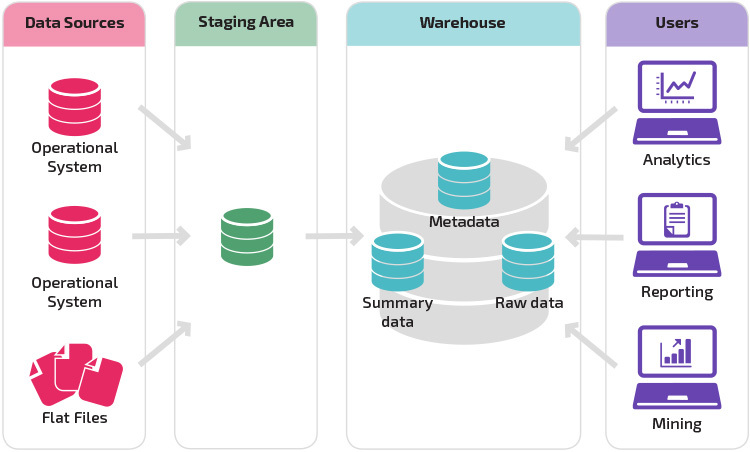

In [35]:
# create a connector to the db
staging_db = create_engine('sqlite:///staging_db.db')

# drop table if exist
conn = staging_db.raw_connection()
cursor = conn.cursor()
command = "DROP TABLE IF EXISTS {};".format('frequentation')
cursor.execute(command)
conn.commit()
cursor.close()

In [36]:
# create index on date for faster retrieval

meta = MetaData()

frequentation = Table('frequentation', meta,
                      Column('index', Integer, primary_key=True,
                             autoincrement=True),
                      Column('site_type', String(5)),
                      Column('date', Date,  index=True),
                      Column('prevision', Integer),
                      Column('reel', Integer),
                      Column('cantine_nom', String(50)),
                      Column('annee_scolaire', String(30)),
                      Column('Effectif', Integer),
                      Column('vacances_dans', Integer),
                      Column('depuis_vacances', Integer),
                      Column('ferie_dans', Integer),
                      Column('depuis_ferie', Integer),
                      Column('chretiennes_dans', Integer),
                      Column('depuis_chretiennes', Integer),
                      Column('juives_dans', Integer),
                      Column('depuis_juives', Integer),
                      Column('ramadan_dans', Integer),
                      Column('depuis_ramadan', Integer),
                      Column('musulmanes_dans', Integer),
                      Column('depuis_musulmanes', Integer),
                      Column('chretiennes', Integer),
                      Column('juives', Integer),
                      Column('ramadan', Integer),
                      Column('musulmanes', Integer),
                      Column('greve', Integer),
                      Column('Quartier_detail', String(50)),
                      Column('prix_Quartier_detail_m2_appart', Float),
                      Column('prix_moyen_m2_appartement', Float),
                      Column('prix_moyen_m2_maison', Float),
                      Column('Longitude', Float),
                      Column('Latitude', Float),
                      Column('Plat', Text)
                      )

frequentation.create(staging_db)

In [37]:
data.columns

Index(['site_type', 'date', 'prevision', 'reel', 'cantine_nom',
       'annee_scolaire', 'Effectif', 'vacances_dans', 'depuis_vacances',
       'ferie_dans', 'depuis_ferie', 'chretiennes_dans', 'depuis_chretiennes',
       'juives_dans', 'depuis_juives', 'ramadan_dans', 'depuis_ramadan',
       'musulmanes_dans', 'depuis_musulmanes', 'chretiennes', 'juives',
       'ramadan', 'musulmanes', 'greve', 'Quartier_detail',
       'prix_Quartier_detail_m2_appart', 'prix_moyen_m2_appartement',
       'prix_moyen_m2_maison', 'Longitude', 'Latitude', 'Plat'],
      dtype='object')

In [38]:
data.to_sql('frequentation', staging_db, if_exists='append')

In [39]:
# query against the table 

conn = staging_db.raw_connection()
cursor = conn.cursor()
cursor.execute("Select * from frequentation limit 2")

for row in cursor.fetchall():
    print(row)

conn.commit()
cursor.close()

(0, 'M/E', '2011-01-03 00:00:00.000000', 210, 182, 'AMPERE', '2010-2011', 280, 54, 0, 112, 0, 3, 0, 76, 0, 210, 0, 43, 0, 0, 0, 0, 0, 0, 'Zola', 3424.0, 3436.0, 4226.0, 1.5847, 47.2115, 'hachis parmentier pamplemousse salade verte flan caramel')
(1, 'M/E', '2011-01-03 00:00:00.000000', 100, 93, 'JACQUES TATI', '2010-2011', 185, 54, 0, 112, 0, 3, 0, 76, 0, 210, 0, 43, 0, 0, 0, 0, 0, 0, 'Nantes Sud', 3155.0, 3270.0, 3419.0, 1.5267, 47.1948, 'hachis parmentier pamplemousse salade verte flan caramel')


In [40]:
data.to_csv('../data/full_data.csv', index=False)